## Define ResNet

In [1]:
from tensorflow.keras.layers import Conv2D,Add, BatchNormalization,UpSampling2D, Activation, concatenate, Input, MaxPool2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
tf.config.run_functions_eagerly(True)

# from cvnn import layers
# import cvnn

from pdb import set_trace
# import tensorflow_datasets as tfds
import scipy
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
import cmath
import scipy.io as sio
import numpy as np
from tqdm import tqdm

In [2]:
def avg_NSR(Y_true, Y_pred):
    signal = tf.norm(tf.reshape(Y_true, [tf.shape(Y_true)[0], -1]), axis=1)
    noise = tf.norm(tf.reshape(Y_true - Y_pred, [tf.shape(Y_true)[0], -1]), axis=1)

    return tf.math.reduce_mean(noise / signal)

In [3]:
def avg_log_SNR(Y_true, Y_pred):
    signal = tf.norm(tf.reshape(Y_true, [tf.shape(Y_true)[0], -1]), axis=1)
    noise = tf.norm(tf.reshape(Y_true - Y_pred, [tf.shape(Y_true)[0], -1]), axis=1)

    return tf.math.reduce_mean(20. * tf.math.log(signal / noise) / tf.math.log(10.0))

In [4]:
def BatchActivate(x, act=True):
    x = BatchNormalization()(x)
    if act == True:
        x = Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = BatchActivate(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = BatchActivate(shortcut, act=False)
    
    output = Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = BatchActivate(shortcut, act=False)
    
    output = Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    # print(u.shape)
    # u = tf.keras.layers.Cropping2D(cropping=())
    c = Concatenate()([u, xskip])
    return c

In [5]:
def Unet(input_size, input_channels, filters):

    # set up input
    X = Input(shape=(input_size, input_size, input_channels))
    
    ### Encoder path

    # convolution pre-processing
    E = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(X)
    E = BatchActivate(E)

    # convolutions 1
    E = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(E)
    E = BatchActivate(E)

    E = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(E)
    E_skip_1 = BatchActivate(E)
   
    

    # pooling 1
    E = MaxPool2D(pool_size=2, strides=2, padding='valid')(E_skip_1)

    # convolutions 2
    E = Conv2D(filters=2*filters, kernel_size=3, strides=1, padding='same')(E)
    E = BatchActivate(E)

    E = Conv2D(filters=2*filters, kernel_size=3, strides=1, padding='same')(E)
    E_skip_2 = BatchActivate(E)
    

    # pooling 2
    E = MaxPool2D(pool_size=2, strides=2, padding='valid')(E_skip_2)

    # convolutions 3
    E = Conv2D(filters=4*filters, kernel_size=3, strides=1, padding='same')(E)
    E = BatchActivate(E)
    
    
    E = Conv2D(filters=4*filters, kernel_size=3, strides=1, padding='same')(E)
    E_skip_3 = BatchActivate(E)
   

    # pooling 3
    E = MaxPool2D(pool_size=2, strides=2, padding='valid')(E_skip_3)

    # convolutions 4
    E = Conv2D(filters=8*filters, kernel_size=3, strides=1, padding='same')(E)
    E = BatchActivate(E)

    E = Conv2D(filters=8*filters, kernel_size=3, strides=1, padding='same')(E)
    E_skip_4 = BatchActivate(E)
    

    # # pooling 4
    E = MaxPool2D(pool_size=2, strides=2, padding='valid')(E_skip_4)

    # convolutions 5
    E = Conv2D(filters=16*filters, kernel_size=3, strides=1, padding='same')(E)
    E = BatchActivate(E)

    E = Conv2D(filters=16*filters, kernel_size=3, strides=1, padding='same')(E)
    E = BatchActivate(E)
    
    
    
    ### Decoder path

    # # upconvolution and concatenation 1
    D = Conv2DTranspose(filters=8*filters, kernel_size=2, strides=2, padding='valid')(E)
    D = BatchActivate(D)

    D = concatenate([E_skip_4, D])

    # convolutions 6
    D = Conv2D(filters=8*filters, kernel_size=3, strides=1, padding='same')(D)
    D = BatchActivate(D)

    D = Conv2D(filters=8*filters, kernel_size=3, strides=1, padding='same')(D)
    D = BatchActivate(D)

    # upconvolution and concatenation 2
    D = Conv2DTranspose(filters=4*filters, kernel_size=2, strides=2, padding='valid')(D)   #(D)
    D = BatchActivate(D)
    

    D = concatenate([E_skip_3, D])
    

    # convolutions 7
    D = Conv2D(filters=4*filters, kernel_size=3, strides=1, padding='same')(D)
    D = BatchActivate(D)

    D = Conv2D(filters=4*filters, kernel_size=3, strides=1, padding='same')(D)
    D = BatchActivate(D)

    # upconvolution and concatenation 3
    D = Conv2DTranspose(filters=2*filters, kernel_size=2, strides=2, padding='valid')(D)
    D = BatchActivate(D)

    D = concatenate([E_skip_2, D])

    # convolutions 8
    D = Conv2D(filters=2*filters, kernel_size=3, strides=1, padding='same')(D)
    D = BatchActivate(D)

    D = Conv2D(filters=2*filters, kernel_size=3, strides=1, padding='same')(D)
    D = BatchActivate(D)

    # upconvolution and concatenation 4
    D = Conv2DTranspose(filters=filters, kernel_size=2, strides=2, padding='valid')(D)
    D = BatchActivate(D)

    D = concatenate([E_skip_1, D])

    # convolutions 9
    D = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(D)
    D = BatchActivate(D)

    D = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(D)
    D = BatchActivate(D)

    # convolution post-processing
    D = Conv2D(filters=input_channels, kernel_size=1, strides=1, padding='same')(D)

    # final concatenation and convolution
    # D = X+D

    # set up model and compile
    model = Model(inputs=X, outputs=D)
    # model.compile(optimizer=Adam(learning_rate=0.00001), loss=avg_NSR, metrics=[avg_log_SNR])
    model.compile(optimizer='adam', loss=avg_NSR, metrics=[avg_log_SNR])
    model.summary()
    

    return model





## Read Data

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [7]:
ph_size = 128
path = "../../../Dataset/sensor_domain/Final/dataset_150_backprojection/*"
test_size = 0.3

In [8]:
def read_data(path, test_size=0.25):
    
    ground_truth = []
    sensor_data = []
    count = 0
    for filename in tqdm(glob.glob(path)):
        mat = sio.loadmat(filename)
        truth = mat["gt"]
        inp = mat["back_P"]

        min_gt = np.amin(truth)
        max_gt = np.amax(truth)
    
        min_inp = np.amin(inp)
        max_inp = np.amax(inp)
    
        # sensor_norm = mat["sensor_norm"]
        
        truth = (truth - min_gt) / (max_gt - min_gt)
        inp = (inp - min_inp) / (max_inp - min_inp)

        gt = truth
        # gt = np.expand_dims(gt, axis=0)
        # sensor_norm = np.expand_dims(sensor_norm, axis=0)

        # temp = np.append(sensor_norm.real, sensor_norm.imag)
        temp = np.reshape(inp, (ph_size, ph_size))
        temp = np.asarray(temp)
        ground_truth.append(gt)
        sensor_data.append(temp)
    temp_gt = []
    temp_sens = []
    for i in range(len(ground_truth)):
        if np.isnan(ground_truth[i]).any() == False:
            temp_gt.append(ground_truth[i])
            temp_sens.append(sensor_data[i])
    ground_truth = temp_gt
    sensor_data = temp_sens
    
#     ground_truth = [i for i in ground_truth if np.isnan(i).any() == False]
#     sensor_data = [i for i in sensor_data if np.isnan(i).any() == False]
    
    X_train, X_test, y_train, y_test = train_test_split(sensor_data,ground_truth, test_size=test_size, random_state=22)
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    # X_train = np.reshape(X_train, (np.asarray(X_train).shape[0], 1, np.asarray(X_train).shape[1]))
    # X_test = np.reshape(X_test, (np.asarray(X_test).shape[0], 1, np.asarray(X_test).shape[1]))
    # y_train = np.reshape(y_train, (np.asarray(y_train).shape[0], 1, np.asarray(y_train).shape[1]))
    # y_test = np.reshape(y_test, (np.asarray(y_test).shape[0], 1, np.asarray(y_test).shape[1]))
    # X_train = np.expand_dims(X_train, axis=-1)
    # X_test = np.expand_dims(X_test, axis=-1)
    # y_train = np.expand_dims(y_train, axis=-1)
    # y_test = np.expand_dims(y_test, axis=-1)
    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = read_data(path, test_size=test_size)

print("Data read : \nX_train = {}\ny_train = {}\nX_test = {}\ny_test = {}".format(len(X_train), len(y_train), len(X_test), len(y_test)))
X_test.shape

100%|██████████| 14100/14100 [00:13<00:00, 1024.25it/s]


Data read : 
X_train = 9870
y_train = 9870
X_test = 4230
y_test = 4230


(4230, 128, 128)

## Train Model

In [10]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,CSVLogger
import matplotlib.pyplot as plt

import glob
import scipy.io
import numpy as np
from skimage.measure import profile_line
from datetime import datetime

In [11]:
input_size = 128
channels = 1
filters = 64
model = Unet(input_size, channels, filters)

2022-08-31 10:38:43.172160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 10:38:43.176038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 10:38:43.176171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 10:38:43.176702: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1) #early stop incase no improvement in the validation loss
checkpoint = ModelCheckpoint(filepath='./model_checkpoints/', save_best_only=True, save_weights_only=True,monitor='val_avg_log_SNR', mode='max', verbose=1) # store the weights
log_csv = CSVLogger('backprojection_logs.csv', separator=',', append=False) #### To store the train and validation loss
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                               patience=6, min_lr=0.0000001) # reduce the learning rate incase we want

save_best_model = tf.keras.callbacks.ModelCheckpoint("Checkpoints/model_unet_backprojection.hdf5", monitor='val_loss', save_best_only=True, verbose=1)

callbacks_list = [log_csv, save_best_model] ### If we need early stop add that parameter here 


In [13]:
start = datetime.now()
# model = tf.keras.models.load_model("Weights/resnet_100_1e3/", compile=False)
# model.compile(optimizer=Adam(learning_rate = 1e-3), loss=avg_NSR, metrics=[avg_log_SNR])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=50)

end = datetime.now()
time_taken = end - start
print('Time: ',time_taken) 

/home/fistlab/anaconda3/envs/tf310/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2022-08-31 10:38:44.264897: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 646840320 exceeds 10% of free system memory.
2022-08-31 10:38:44.327166: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 646840320 exceeds 10% of free system memory.
2022-08-31 10:38:44.520195: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-08-31 10:38:44.770705: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-08-31 10:38:45.016458: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-31 10:38:45.016703: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-31 10:38:45.016717: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-08-31 10:38:45.016953: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-31 10:38:45.016993: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


617/617 [==============================] - 148s 233ms/step - loss: 0.3626 - avg_log_SNR: 11.7424 - val_loss: 0.2312 - val_avg_log_SNR: 13.4090
Epoch 2/50
617/617 [==============================] - 140s 228ms/step - loss: 0.1363 - avg_log_SNR: 17.9586 - val_loss: 0.1166 - val_avg_log_SNR: 19.0793
Epoch 3/50
617/617 [==============================] - 141s 228ms/step - loss: 0.1063 - avg_log_SNR: 19.9816 - val_loss: 0.1225 - val_avg_log_SNR: 18.7031
Epoch 4/50
617/617 [==============================] - 141s 229ms/step - loss: 0.1004 - avg_log_SNR: 20.5189 - val_loss: 0.4960 - val_avg_log_SNR: 11.2401
Epoch 5/50
617/617 [==============================] - 141s 229ms/step - loss: 0.1047 - avg_log_SNR: 20.2625 - val_loss: 0.1085 - val_avg_log_SNR: 19.6162
Epoch 6/50
617/617 [==============================] - 141s 229ms/step - loss: 0.0911 - avg_log_SNR: 21.3418 - val_loss: 0.1023 - val_avg_log_SNR: 20.1550
Epoch 7/50
617/617 [==============================] - 141s 228ms/step - loss: 0.0862 - 

KeyboardInterrupt: 

/home/fistlab/anaconda3/envs/tf310/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


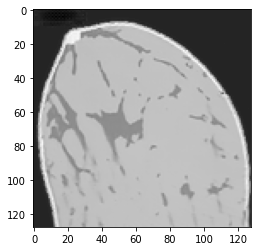

In [45]:
x=431

test = model.predict(np.expand_dims(X_test[x], axis=0))
plt.imshow(test.squeeze(), cmap='gray')
# plt.imsave('Images/back_recon_150.png', test.squeeze(), cmap='gray')

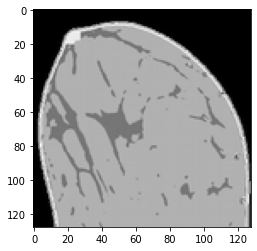

In [38]:
train = y_test[x]
plt.imshow(train, cmap='gray')

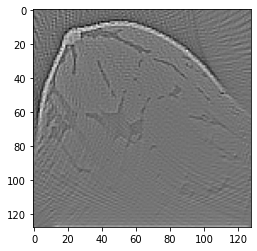

In [44]:
train = X_test[x]
plt.imshow(train, cmap='gray')
# plt.imsave('Images/back_recon_unet_150.png', train, cmap='gray')

In [22]:
model.save("Checkpoints/unet_back_proj_final_2")

2022-08-31 11:31:04.220329: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Checkpoints/unet_back_proj_final_2/assets


# UNet Recon

In [40]:
model = tf.keras.models.load_model("Checkpoints/model_unet_recon.hdf5", compile=False)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss=avg_NSR, metrics=[avg_log_SNR])

In [17]:
# pred_array = []
# gt_array = []
# for i in range(len(X_test)):
#     test = model.predict(np.expand_dims(X_test[i], axis=0))
#     pred = test.squeeze()

#     pred_array.append(pred)
#     gt_array.append(y_test[i])

# pred_array = np.asarray(pred_array)
# gt_array = np.asarray(gt_array)

# sio.savemat('Results/unet_40_300.mat', dict(gt=gt_array, pred=pred_array))

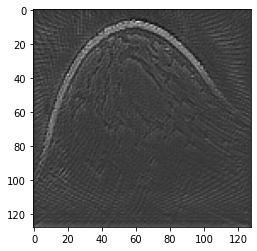

In [62]:
x=6

test = model.predict(np.expand_dims(X_test[x], axis=0))
img = plt.imshow(test.squeeze(), cmap='gray')
# plt.imsave("Images/unet_recon_150.png", test.squeeze(), cmap='gray')

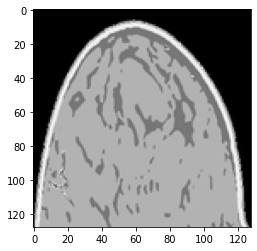

In [63]:
train = y_test[x]
plt.imshow(train, cmap='gray')
plt.imsave("Images/gt_recon_150.png", train.squeeze(), cmap='gray')

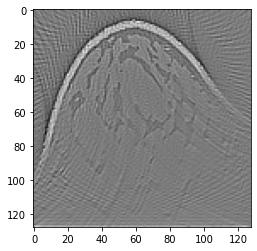

In [64]:
train = X_test[x]
plt.imshow(train, cmap='gray')
# plt.imsave("Images/tikh_recon_150.png", train.squeeze(), cmap='gray')

In [10]:
def read_data(path, test_size=0.25):
    
    ground_truth = []
    sensor_data = []
    count = 0
    for filename in glob.glob(path):
        mat = sio.loadmat(filename)
        truth = mat["gt"]
        sensor = mat["P"]

        # sensor = normalize_sensor_data(sensor)
        
        
        # gt = (truth - min_gt) / (max_gt - min_gt)
        # gt = np.expand_dims(gt, axis=0)
        # sensor_norm = np.expand_dims(sensor_norm, axis=0)
        temp = sensor
        # print(temp.shape)
        # temp = np.append(sensor.real, sensor.imag)

        # P_min = np.amin(temp)
        # P_max = np.amax(temp)

        # sensor_norm = (temp - P_min) / (temp - P_min)
        # temp = sensor_norm

        # temp = np.reshape(temp, (ph_size, ph_size))
        temp = np.asarray(temp)
        ground_truth.append(truth)
        sensor_data.append(temp)
    temp_gt = []
    temp_sens = []
    for i in range(len(ground_truth)):
        if np.isnan(ground_truth[i]).any() == False:
            temp_gt.append(ground_truth[i])
            temp_sens.append(sensor_data[i])
    ground_truth = temp_gt
    sensor_data = temp_sens
    
#     ground_truth = [i for i in ground_truth if np.isnan(i).any() == False]
#     sensor_data = [i for i in sensor_data if np.isnan(i).any() == False]
    
    X_train, X_test, y_train, y_test = train_test_split(sensor_data,ground_truth, test_size=test_size, random_state=22)
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    # X_train = np.reshape(X_train, (np.asarray(X_train).shape[0], 1, np.asarray(X_train).shape[1]))
    # X_test = np.reshape(X_test, (np.asarray(X_test).shape[0], 1, np.asarray(X_test).shape[1]))
    # y_train = np.reshape(y_train, (np.asarray(y_train).shape[0], 1, np.asarray(y_train).shape[1]))
    # y_test = np.reshape(y_test, (np.asarray(y_test).shape[0], 1, np.asarray(y_test).shape[1]))
    # X_train = np.expand_dims(X_train, axis=-1)
    # X_test = np.expand_dims(X_test, axis=-1)
    # y_train = np.expand_dims(y_train, axis=-1)
    # y_test = np.expand_dims(y_test, axis=-1)
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = read_data(path, test_size=test_size)

print("Data read : \nX_train = {}\ny_train = {}\nX_test = {}\ny_test = {}".format(len(X_train), len(y_train), len(X_test), len(y_test)))
X_test.shape

Data read : 
X_train = 9870
y_train = 9870
X_test = 4230
y_test = 4230


(4230, 128, 64)

In [15]:
x = 1647
sio.savemat('test_recon/5.mat', dict(P=X_test[x], gt=y_test[x]))



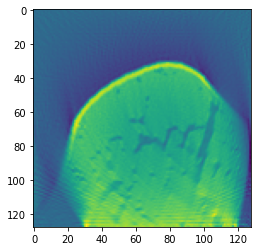

In [16]:
plt.imshow(X_test[x])

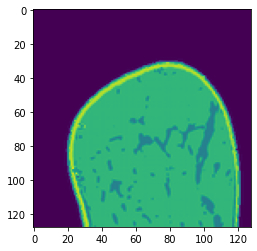

In [17]:
plt.imshow(y_test[x])

In [19]:
x = 2931
sio.savemat('test_back/10.mat', dict(P=X_test[x], gt=y_test[x]))